# Load data

In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
data_path = '/content/drive/My Drive/WorkSpace/MLstudy/GDSO2019/data/'

Mounted at /content/drive/


In [0]:
!pip install keras_vggface

### Load VGGface

- caveat : VGGface input is not normlaized to [0,1] range. Instead use [0,255] range

In [0]:
from keras_vggface.vggface import VGGFace
vggface = VGGFace(model='resnet50', include_top=False, input_shape = (224,224,3))
vggface.trainable = True
vggface.summary()

Using TensorFlow backend.










Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________

### load preprocessed FER2013 data
- preprocessing on the [raw-data](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) is done from [here](https://colab.research.google.com/drive/1wODmKb-2OhnRYAs0m94187Y2YVi1Liyz?authuser=1#scrollTo=muk6Dt1WtS1u)

In [0]:
import pickle
with open(data_path+'FER2013.train_data.pickle','rb') as f:
  train_data = pickle.load(f)
with open(data_path+'FER2013.public_test_data.pickle','rb') as f:
  validation_data = pickle.load(f)
with open(data_path+'FER2013.private_test_data.pickle','rb') as f:
  test_data = pickle.load(f)

In [0]:
print('feature and label shape')
print('train data      :',train_data['x'].shape, train_data['y'].shape)
print('validation data :',validation_data['x'].shape, validation_data['y'].shape)
print('test data       :',test_data['x'].shape, test_data['y'].shape)
sample_count = len(train_data['y'])
emotion_dict = {0: 'Angry', 1:'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6:'Neutral'}

feature and label shape
train data      : (28709, 48, 48, 1) (28709, 7)
validation data : (3589, 48, 48, 1) (3589, 7)
test data       : (3589, 48, 48, 1) (3589, 7)


In [0]:
print(train_data['x'].max(),validation_data['x'].max(),test_data['x'].max())

1.0 1.0 1.0


In [0]:
train_data['x'] = train_data['x']*255
validation_data['x'] = validation_data['x']*255
test_data['x'] = test_data['x']*255

# Definitions

### show image samples

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

def show_image_samples(feature_iter,label_iter,class_dict,n_show=16):
  n_col = min([4,n_show])
  n_row = ceil(n_show/4.0)
  plt.figure(figsize=(3*n_col,3*n_row))
  for i in range(n_show):
    plt.subplot(n_row,n_col,i+1)
    feature = feature_iter.__getitem__(i)
    label = label_iter.__getitem__(i)
    if len(feature.shape)==2: 
      plt.imshow(feature/255)
    else:
      assert len(feature.shape)==3
      if len(feature[0,0,:])==1:
        plt.imshow(feature[:,:,0]/255,'gray')
      else:
        plt.imshow(feature/255)
    if isinstance(label,int):
      plt.title(class_dict[label])
    else:
      assert len(label) == len(class_dict)
      plt.title(class_dict[np.argmax(label)])
  plt.tight_layout()
  plt.show()

### smooth labels

In [0]:
from copy import deepcopy as copy

def smooth_labels(y, smooth_factor):
    '''Convert a matrix of one-hot row-vector labels into smoothed versions.

    # Arguments
        y: matrix of one-hot row-vector labels to be smoothed
        smooth_factor: label smoothing factor (between 0 and 1)

    # Returns
        A matrix of smoothed labels.
    '''
    assert len(y.shape) == 2, 'input should be a batch of one-hot-encoded data'
    y2 = copy(y)
    if 0 <= smooth_factor <= 1:
        # label smoothing ref: https://www.robots.ox.ac.uk/~vgg/rg/papers/reinception.pdf
        y2 *= 1 - smooth_factor
        y2 += smooth_factor / y.shape[1]
    else:
        raise Exception(
            'Invalid label smoothing factor: ' + str(smooth_factor))
    return y2

### data sequence
- base-class : keras.utils.Sequenece
- resize from 48x48 to 224x224, gray scale to color

In [0]:
from keras.utils import Sequence
from keras.utils import to_categorical
import cv2
from math import floor

class data_sequence(Sequence):
    '''
      yield sequence of data
      features -- list of features
      labels -- list of labels
      target_channels {int} -- 1 (gray) or 3(RGB)
    '''
    def __init__(self, features, labels, batch_size=128, target_dim=(224,224), 
                 n_classes=7, shuffle=True, smooth=0.0, verbose=False):
        'Initialization'
        assert len(features)==len(labels), 'number of feature and labels not consistent'
        self.features = features
        self.labels = labels
        self.batch_size = batch_size
        self.target_dim = target_dim
        self.target_channels = 3
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.smooth = smooth
        self.sample_count = len(labels)
        self.indexes = np.arange(self.sample_count)
        self.on_epoch_end()
        self.verbose = verbose

    def __len__(self):
        'Denotes the number of batches per epoch'
        return floor(self.sample_count / self.batch_size)

    def __gray2RGB__(self,x):
      if len(x.shape)==2:
        return np.stack((x,x,x),-1)
      else:
        assert len(x.shape)==3
        if len(x[0,0,:]) == 1:
          return np.stack((x[:,:,0],x[:,:,0],x[:,:,0]),-1)
        else:
          assert len(x[0,0,:])==self.target_channels
      return x


    def __getitem__(self, idx):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, *self.target_dim, self.target_channels))
        Y = np.empty((self.batch_size, self.n_classes))
        for i,ind in enumerate(indexes):
          x = self.features[ind]
          # resize image to the target size 
          x = cv2.resize(x,self.target_dim,interpolation=cv2.INTER_CUBIC)
          X[i] = self.__gray2RGB__(x)
          y = self.labels[ind]
          if isinstance(y,int):
            Y[i]=to_categorical(y,7)
          else:
            assert len(y)==self.n_classes
            Y[i]=y
        X = np.array(X)
        Y = np.array(Y)
        if self.smooth > 0.0:
          smooth_labels(Y, self.smooth)
        return X,Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

##### test

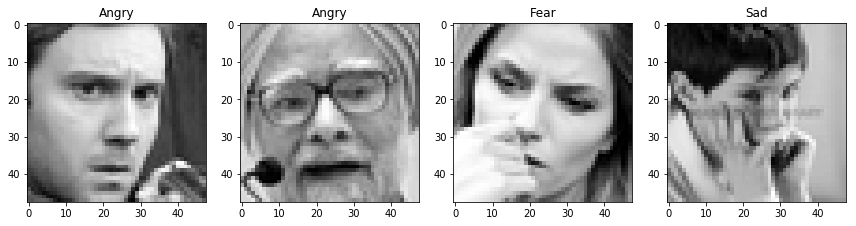

In [0]:
show_image_samples(train_data['x'],train_data['y'],emotion_dict,n_show=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


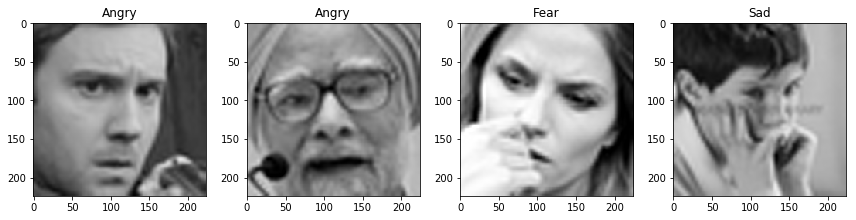

In [0]:
train_sequence = data_sequence(train_data['x'],train_data['y'],batch_size=16,target_dim=(224,224),n_classes=7,shuffle=False)
feature,lable = train_sequence.__getitem__(0)
show_image_samples(feature,lable,emotion_dict,n_show=4)

In [0]:
# tmp = data_sequence(train_data['x'],train_data['y'],batch_size=int(len(train_data['y'])/3),target_dim=(224,224),n_classes=7,shuffle=False)
# train_data['x'],train_data['y'] = tmp.__getitem__(0)

In [0]:
# tmp = data_sequence(validation_data['x'],validation_data['y'],batch_size=len(validation_data['y']),target_dim=(224,224),n_classes=7,shuffle=False)
# validation_data['x'],validation_data['y'] = tmp.__getitem__(0)

### Learning Rate Control : WarmUp + Cos-decay

In [0]:
from keras.callbacks import Callback
import keras.backend as K


def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0,
                             learning_rate_minimum = 0.0): 
    """Cosine decay schedule with warm up period.

    Cosine annealing learning rate as described in:
      Loshchilov and Hutter, SGDR: Stochastic Gradient Descent with Warm Restarts.
      ICLR 2017. https://arxiv.org/abs/1608.03983
    In this schedule, the learning rate grows linearly from warmup_learning_rate
    to learning_rate_base for warmup_steps, then transitions to a cosine decay
    schedule.

    Arguments:
        global_step {int} -- global step.
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.

    Keyword Arguments:
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
        learning_rate_minimum {float} -- minimum learning rate after full decay (default: {0.0})
    Returns:
      a float representing learning rate.

    Raises:
      ValueError: if warmup_learning_rate is larger than learning_rate_base,
        or if warmup_steps is larger than total_steps.
    """

    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to '
                         'warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps))) + learning_rate_minimum
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base + learning_rate_minimum < warmup_learning_rate:
            raise ValueError('learning_rate_base + learning_rate_minimum must be larger or equal to '
                             'warmup_learning_rate.')
        slope = (learning_rate_base + learning_rate_minimum - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, learning_rate_minimum, learning_rate) # keep learing after fully decayed (Kilean)



class WarmUpCosineDecayScheduler(Callback):
    """Cosine decay with warmup learning rate scheduler
    """

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 learning_rate_minimum=0.0,
                 verbose=0):
        """Constructor for cosine decay with warmup learning rate scheduler.

    Arguments:
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.

    Keyword Arguments:
        global_step_init {int} -- initial global step, e.g. from previous checkpoint.
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
        verbose {int} -- 0: quiet, 1: update messages. (default: {0})
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.learning_rate_minimum = learning_rate_minimum
        self.verbose = verbose
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps,
                                      learning_rate_minimum=self.learning_rate_minimum)


        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %05d: setting learning '
                  'rate to %s.' % (self.global_step + 1, lr))

### print test accuracy

In [0]:
class TestCallback(Callback):
  def __init__(self, test_data):
    self.test_data = test_data

  def on_epoch_end(self, epoch, logs={}):
    try:
      x, y = self.test_data
      loss, acc = self.model.evaluate(x, y, verbose=0)
    except:
      _len_ = self.test_data.__len__()
      _batch_size_ = self.test_data.batch_size
      loss = 0.0
      acc = 0.0
      for i in range(_len_):
        x,y = self.test_data.__getitem__(i)
        tmp_loss, tmp_acc = self.model.evaluate(x, y, verbose=0)
        loss = loss + tmp_loss
        acc = acc + tmp_acc
    loss = loss/_len_
    acc = acc/_len_
    print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

### plot training history

In [0]:
def plot_training_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,max(plt.ylim())])
    plt.title('Training and Validation Loss')
    plt.show()

### plot confusion matrix

In [0]:
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn


def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()
#

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 11;
    figsize=[9,9];
    show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)

### plot_single_image_prediction

In [0]:
import cv2
import matplotlib.pyplot as plt

def add_bounding_box_text(image,faces_coord,identified_category):
    for (x, y, w, h) in faces_coord:
        gray_fr = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        fc = gray_fr[y:y+h, x:x+w]
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),4)
        cv2.putText(image, identified_category, (x, y),  cv2.FONT_HERSHEY_SIMPLEX,2, (255, 255, 0), 4)
    return image


def plot_single_image_prediction(image, detector, resized_shape, model,emotion_dict):
    grid = plt.GridSpec(1, 3, wspace=0.4, hspace=0.3)

    faces_coord = detector.detect(image, True)
    faces = normalize_faces(image ,faces_coord,resized_shape,0)
    cropped_faces = np.zeros((len(faces),resized_shape[0],resized_shape[1],3))
    for face_id, face in enumerate(faces):
        cropped_faces[face_id, :,:,: ] = face
    cropped_faces = cropped_faces.astype(int)

    predictions = model.predict(cropped_faces)
    predicted_category = emotion_dict[np.argmax(predictions)]
    image = add_bounding_box_text(image,faces_coord,predicted_category)

    plt.figure(figsize = (20, 6))
    plt.subplot(grid[0, 0])
    plt.imshow(test_image)
    plt.subplot(grid[0, 1:])
    plt.bar(emotion_dict.values(), predictions[0])
    plt.show()

# FineTune
- Fix upto 4th conv blocks of the resnet. i.e. learn last block (1*conv+4*identity) and the classification block

In [0]:
for i,layer in enumerate(vggface.layers):
  if 'conv5' in layer.name:
    break
  layer.trainable =  False
print(i)

141


In [0]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

# model = Sequential([vggface,
#                     Flatten(),
#                     Dropout(0.5),
#                     BatchNormalization(),
#                     Dense(128, activation='relu'),
#                     Dropout(0.5),
#                     BatchNormalization(),
#                     Dense(len(emotion_dict), activation='softmax', name = 'classifer')])
model = Sequential([vggface,
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(len(emotion_dict), activation='softmax', name = 'classifer')])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Model)     (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
classifer (Dense)            (None, 7)                 903       
Total params: 23,824,327
Trainable params: 15,227,911
Non-trainable params: 8,596,416
_________________________________________________________________


In [0]:
np.mod(len(validation_data['y']),78)

1

In [0]:
train_sequence = data_sequence(train_data['x'],train_data['y'],batch_size=78,target_dim=(224,224),n_classes=7,shuffle=True,smooth=0.02)
validation_sequence = data_sequence(validation_data['x'],validation_data['y'],batch_size=78,target_dim=(224,224),n_classes=7,shuffle=True,verbose=True)
test_sequence = data_sequence(test_data['x'],test_data['y'],batch_size=78,target_dim=(224,224),n_classes=7,shuffle=True)

test_acc_callback = TestCallback(test_sequence)

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping


check_point = ModelCheckpoint(data_path+'VGGfaceTransfer.warmUp.cosDecay.LabelSmoothing.hdf5', 
                              monitor='val_acc', verbose=0, save_best_only=True,
                              save_weights_only=False, mode='auto', period=1)

stopping = EarlyStopping(monitor='val_acc',patience=8)



base_batch_size = 256
base_lr = 0.1
batch_size = 78
initial_lr = base_lr * batch_size / base_batch_size
epochs = 100
warmup_epoch = int(epochs*0.1)
warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base=0.001,
                                        total_steps = int(epochs * sample_count / batch_size),
                                        warmup_learning_rate =0.0002,
                                        warmup_steps = int(warmup_epoch * sample_count / batch_size),
                                        hold_base_rate_steps=0,
                                        learning_rate_minimum = 0.0)

In [25]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(generator = train_sequence,
                           validation_data = validation_sequence,
                           callbacks=[check_point, stopping, warm_up_lr, test_acc_callback],
                           epochs = 100)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
368/368 [==============================] - 291s 791ms/step - loss: 1.0457 - acc: 0.6201 - val_loss: 1.5825 - val_acc: 0.4685

Testing loss: 1.507144475860341, acc: 0.47770345758401694

Epoch 2/100
368/368 [==============================] - 282s 766ms/step - loss: 0.8150 - acc: 0.6979 - val_loss: 1.2189 - val_acc: 0.5666

Testing loss: 1.1507374466860971, acc: 0.5783166126197532

Epoch 3/100
368/368 [==============================] - 282s 766ms/step - loss: 0.7132 - acc: 0.7348 - val_loss: 1.0767 - val_acc: 0.5903

Testing loss: 1.0407625084769898, acc: 0.5994983284070737

Epoch 4/100
368/368 [==============================] - 282s 767ms/step - loss: 0.6227 - acc: 0.7721 - val_loss: 1.5452 - val_acc: 0.5022

Testing loss: 1.5241260923603044, acc: 0.5083612053423555

Epoch 5/100
368/368 [==============================] - 282s 767ms/step - loss: 0.5374 - acc: 0.8010 - val_loss: 1.814

In [0]:
import pickle
pickle.dump(hist, open(data_path+'VGGfaceTransfer.warmUp.cosDecay.LabelSmoothing.hist.pickle', "wb" ) )

In [0]:
import pickle
hist = pickle.load(open(data_path+'VGGfaceTransfer.warmUp.cosDecay.LabelSmoothing.hist.pickle', "rb" ) )

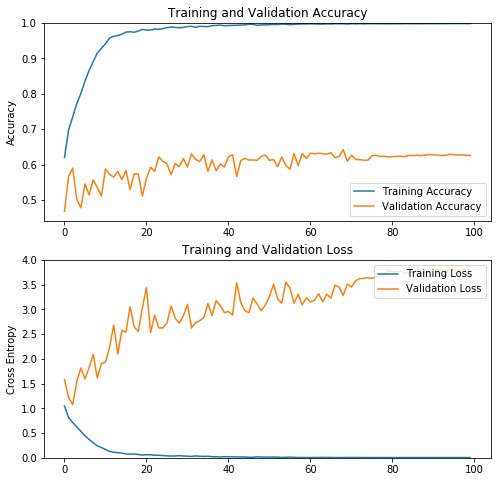

In [33]:
plot_training_history(hist)

max_val_acc= 0.6421404765999835


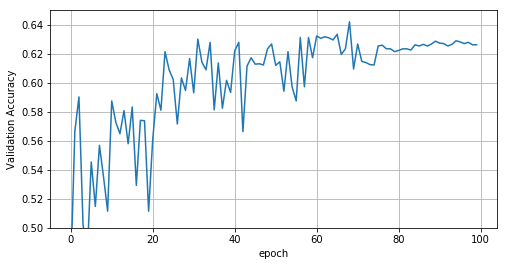

In [40]:
plt.figure(figsize=(8,4))
plt.plot(hist.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('Validation Accuracy')
plt.ylim(0.5,0.65);
plt.grid()
print('max_val_acc=',np.max(hist.history['val_acc']))

In [0]:
from keras.models import load_model
model = load_model(data_path+'VGGfaceTransfer.warmUp.cosDecay.LabelSmoothing.hdf5')

In [35]:
confusion_matrix={'y_true':[],'y_predicted':[]}
for batch in validation_sequence:
  for i in range(len(batch[1])):
    confusion_matrix['y_true'].append(np.argmax(batch[1][i]))
    confusion_matrix['y_predicted'].append(model.model.predict_classes(batch[0][i][None,:])[0])

/usr/local/lib/python3.6/dist-packages/keras/engine/sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


In [0]:
confusion_matrix['y_true'] = np.array(confusion_matrix['y_true'])
confusion_matrix['y_predicted'] = np.array(confusion_matrix['y_predicted'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


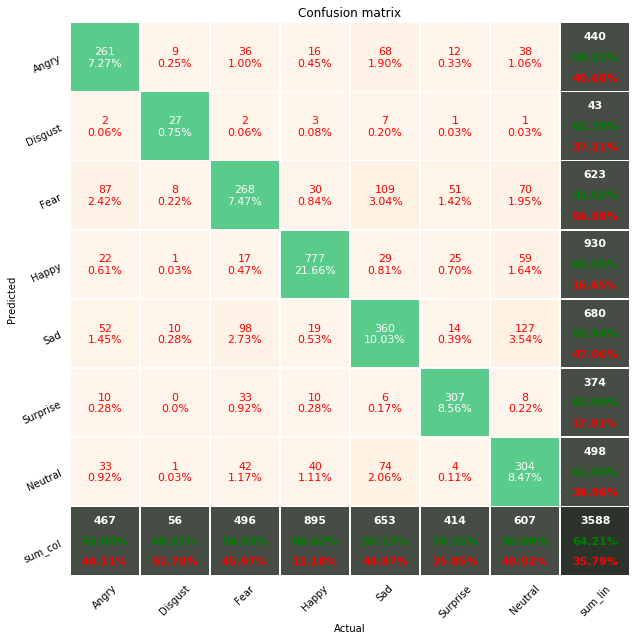

In [37]:
plot_confusion_matrix_from_data(confusion_matrix['y_true'],confusion_matrix['y_predicted'],columns=list(emotion_dict.values()))